In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler, TensorDataset
from torchvision import datasets, models

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

from imblearn.over_sampling import RandomOverSampler

In [2]:
device = 'cuda'

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
dataset = datasets.ImageFolder(root="./Separated_Frames", transform=transform)

In [5]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

In [6]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [7]:
labels = [label for _, label in train_dataset]  # Adjust based on how labels are accessed

# Step 2: Calculate class counts
class_counts = np.bincount(labels)
class_weights = 1. / class_counts

# Step 3: Create sample weights for each instance
sample_weights = [class_weights[label] for label in labels]

# Step 4: Create WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [9]:
def display(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()  # Convert to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Reorder dimensions for displaying
    plt.axis("off")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


1


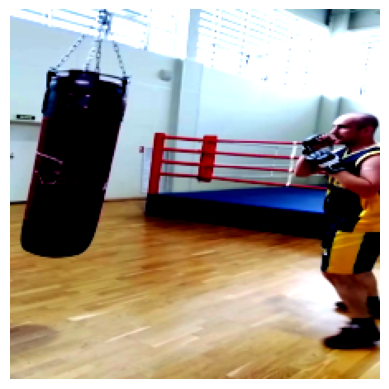

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


1


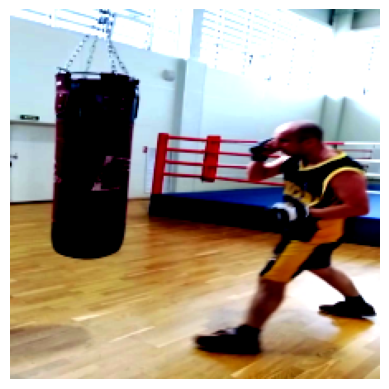

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


0


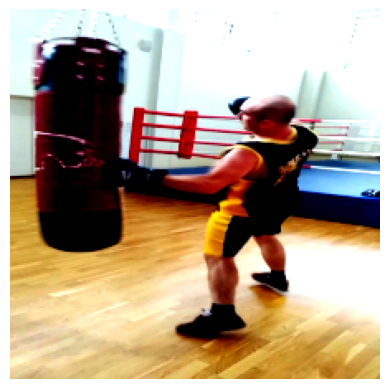

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


0


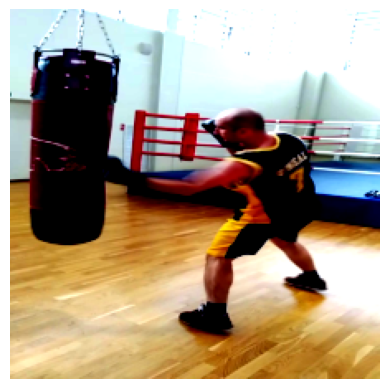

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


1


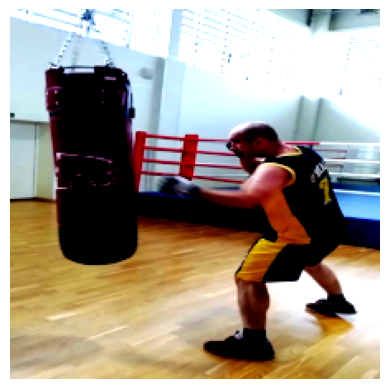

In [10]:
for i in range(5):
    image, label = train_dataset[i]
    print(label)
    display(image)

In [11]:
model = models.resnet50(pretrained=False)

/home/hatsu/miniconda3/envs/cvpython/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hatsu/miniconda3/envs/cvpython/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

model.train()
# Train the Model (example for 1 epoch)
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1, 1).float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 10:.3f}")
            running_loss = 0.0

print("Finished Training")

[1, 10] loss: 0.702
[2, 10] loss: 0.688
[3, 10] loss: 0.717
[4, 10] loss: 0.784
[5, 10] loss: 0.613
Finished Training


In [14]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.sigmoid(model(inputs))
        preds = (outputs > 0.5).int()
        all_preds.append(preds)
        all_labels.append(labels)
    
    all_labels = torch.cat(all_labels).cpu().numpy()
    all_preds = torch.cat(all_preds).cpu().numpy()

    all_labels = all_labels.flatten()
    all_preds = all_preds.flatten()

    report = classification_report(all_labels, all_preds)
    print(report)


              precision    recall  f1-score   support

           0       0.73      0.56      0.63        34
           1       0.81      0.90      0.85        71

    accuracy                           0.79       105
   macro avg       0.77      0.73      0.74       105
weighted avg       0.78      0.79      0.78       105

